# Modeling Notebook

In [1]:
# import packages
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.metrics import Precision, Recall
from keras.optimizers import Adam
import seaborn as sns
from src.modeling import get_history_graph, custom_fit, custom_compile, get_score_graph, get_roc, roc_graph
%load_ext autoreload
%autoreload 2

## Method

To begin the modeling process, the training data is loaded in and split into a 80% training set and a 20% validation set.  The data is normalized with StandardScaler to reduce the distance between points, allowing for clusters within the data to be spotted more easily, and to reduce exploding/vanishing weights causing the model to diverge.  Model architecture will be fit on the training data, using validation data to diagnose the bias-variance relationship.  In each iteration, the metrics and level of overfitting will be examined.  In subsequent iterations, dropout will be used as the primary regularization method in order to achieve a generalizable model. The method of compiling will use adaptive moment estimation with a learning rate of 0.00001 for the optimization function, and because this is a binary classification, the loss function will be binary crossentropy.  The model is fit with minibatches of size 32, over 100 epochs.

In [2]:
# load in the data
df = pd.read_csv('../data/streamer_data.csv')
# drop unnecessary columns
df = df.drop(columns = ['game_name', 'login', 'broadcaster_type', 'language'])
# change dtype from string to timedelta
df.account_age = pd.to_timedelta(df.account_age).map(lambda x: x.days)
# store the labels for each feature
labels = df.columns
# split the target (partnership status) from the features into separate dataframes
X = df.drop(columns = 'target')
# data is scaled with standardscaler to prevent exploding/vanishing terms
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df.target
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [3]:
# pickle the scaler for future use on holdout data
from pickle import dump
dump(scaler, open('../data/scaler.pkl', 'wb'))

In [5]:
# load pickled scaler
from pickle import load
scaler = load(open('../data/scaler.pkl', 'rb'))

## Selection

Once the performance of the models plateau, the best performing model will be used to predict on the holdout data set.  The scores being examined will be f1, accuracy, recall, and precision.  The final selected model will be one that achieves a high precision for a specific threshold of the sigmoid output.  Precision is the key metric, with the goal of minimizing false positives.  In this situation, due to the automated nature of this partnership approval model, it should be stricter than it is lenient in regards to classifying a channel as a partner.  We do not want the model to incorrectly assign channels partnership, because partnership is usually permanent, while denied applications can be resubmitted after a month. 

### Model 1

A neural network will be used as the binary classifier.  The architecture will follow the structure 

Input -> Hidden Layers -> Output

where the Input is the number of features, and the output is a Dense 1 node with sigmoid activation.  This output is a number between 0 and 1, will then be interpreted as a positive or negative class if the number is above the threshold.  For a baseline, a simple 1 fully connected hidden layer is used.

In [3]:
# instantiate a sequential NN
model_1 = Sequential()
# specify the size of the input, in this case (18,) because there are 18 features
model_1.add(Input(18,))
# fully connected layer with 32 nodes as a baseline architecture
model_1.add(Dense(32))
# ReLu activation function
model_1.add(Activation('relu'))

# output layer, 1 node with sigmoid activation
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# compile the model using adaptive moment estimation optimization and binary crossentropy as the loss function
custom_compile(model_1)
# fit the model on the training set, using the 30% validation set.
history_1 = custom_fit(model_1, X_train, y_train, X_test, y_test)

Epoch 1/100
739/739 [==============================] - 1s 994us/step - loss: 0.1668 - acc: 0.9488 - prec: 0.5192 - recall: 0.4733 - val_loss: 0.0729 - val_acc: 0.9760 - val_prec: 0.8802 - val_recall: 0.6221
Epoch 2/100
739/739 [==============================] - 1s 693us/step - loss: 0.0682 - acc: 0.9764 - prec: 0.8904 - recall: 0.6343 - val_loss: 0.0613 - val_acc: 0.9766 - val_prec: 0.9082 - val_recall: 0.6124
Epoch 3/100
739/739 [==============================] - 1s 714us/step - loss: 0.0598 - acc: 0.9788 - prec: 0.8764 - recall: 0.7004 - val_loss: 0.0574 - val_acc: 0.9770 - val_prec: 0.8701 - val_recall: 0.6547
Epoch 4/100
739/739 [==============================] - 1s 774us/step - loss: 0.0559 - acc: 0.9802 - prec: 0.8736 - recall: 0.7323 - val_loss: 0.0557 - val_acc: 0.9794 - val_prec: 0.8364 - val_recall: 0.7492
Epoch 5/100
739/739 [==============================] - 1s 695us/step - loss: 0.0535 - acc: 0.9810 - prec: 0.8652 - recall: 0.7618 - val_loss: 0.0528 - val_acc: 0.9794 - val

In [4]:
# calculate the metrics on the validation set
score = model_1.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.04955637454986572
Test accuracy: 0.9796885848045349
Test precision: 0.8327401876449585
Test recall: 0.7622149586677551


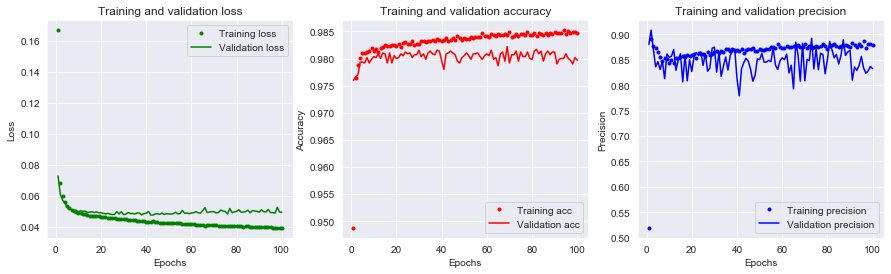

In [5]:
# show the history of the epochs
get_history_graph(history_1)

The charts above visualize the loss and accuracy of the model as a function of its training epochs.  Both the training and validation show slight amounts of noise, indicating that one hidden layer with no regularization might not be the best architecture for this problem, or the number of nodes is not ideal for this set of data. Additionally, as the number of epochs increases, the model becomes less accurate on the validation set, indicating a slight degree of overfitting.  The model performs somewhat well on the validation set, however to make the model more generalizable in subsequent iterations regularization will be used.

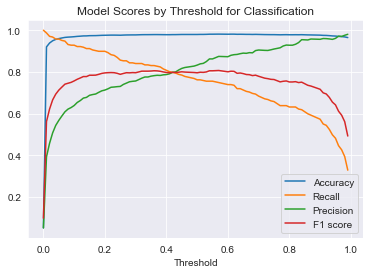

In [6]:
get_score_graph(model_1, X_test, y_test)

The figure above shows the scores as a function of the threshold for classification.  The point where the scores converge is where the F1 score is the highest, indicating that the recall and precision are the same.  In this case the precision is the most important metric, so the threshold can be adjusted to minimize the number of false positives.

In [22]:
model_1.save('../models/model_1.h5')

### Model 2

In the second iteration, and additional fully connected layer with double the nodes is added.  In addition, to regulate overfitting a dropout of 0.2 is added after each hidden layer but before the RELU activation.

In [28]:
model_2 = Sequential()

# Input layer
model_2.add(Input(18,))

# First hidden layer
model_2.add(Dense(32))
model_2.add(Dropout(0.2))
model_2.add(Activation('relu'))

# Second hidden layer
model_2.add(Dense(64))
model_2.add(Dropout(0.2))
model_2.add(Activation('relu'))

# Output layer
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Compile and fit
custom_compile(model_2)
history_2 = custom_fit(model_2, X_train, y_train, X_test, y_test)

Epoch 1/100
739/739 [==============================] - 1s 1ms/step - loss: 0.1288 - acc: 0.9592 - prec: 0.6629 - recall: 0.4733 - val_loss: 0.0641 - val_acc: 0.9777 - val_prec: 0.8889 - val_recall: 0.6515
Epoch 2/100
739/739 [==============================] - 1s 828us/step - loss: 0.0694 - acc: 0.9764 - prec: 0.8400 - recall: 0.6861 - val_loss: 0.0577 - val_acc: 0.9778 - val_prec: 0.8359 - val_recall: 0.7134
Epoch 3/100
739/739 [==============================] - 1s 838us/step - loss: 0.0641 - acc: 0.9780 - prec: 0.8254 - recall: 0.7418 - val_loss: 0.0555 - val_acc: 0.9775 - val_prec: 0.8085 - val_recall: 0.7427
Epoch 4/100
739/739 [==============================] - 1s 810us/step - loss: 0.0602 - acc: 0.9787 - prec: 0.8274 - recall: 0.7562 - val_loss: 0.0558 - val_acc: 0.9807 - val_prec: 0.8939 - val_recall: 0.7134
Epoch 5/100
739/739 [==============================] - 1s 805us/step - loss: 0.0579 - acc: 0.9804 - prec: 0.8436 - recall: 0.7737 - val_loss: 0.0539 - val_acc: 0.9802 - val_p

In [29]:
score = model_2.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.052884556353092194
Test accuracy: 0.9795193076133728
Test precision: 0.8842975497245789
Test recall: 0.6970683932304382


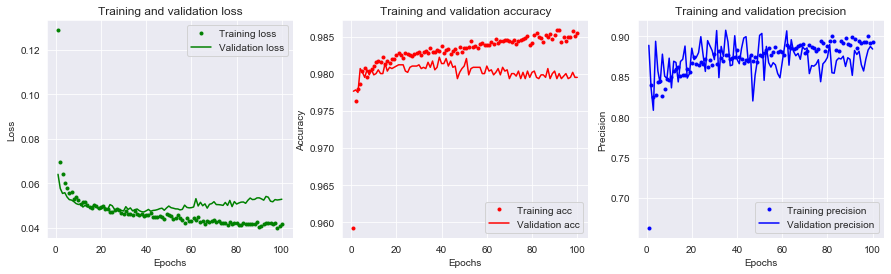

In [30]:
get_history_graph(history_2)

As shown in the figures above, the second iteration diverges as the epochs increase, indicating a degree of overfitting, and resulting loss in accuracy on the validation set.  The model does well in early (40) epochs, however the large amount of variance in the precision on the validation set shows that the model is still sensitive to noise.

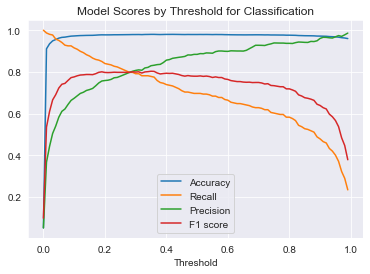

In [31]:
get_score_graph(model_2, X_test, y_test)

For this iteration, the optimal threshold for classification would be around 0.4, slightly higher than for the previous model.

In [32]:
model_2.save('../models/model_2.h5')

### Model 3

For the third iteration, a reduction in complexity will be applied in order to address the amount of noise.  Perhaps the data is not complex enough to warrant using many nodes and few nodes will perform better.  The number of nodes has thus been reduced from 32 to 8 nodes in the first layer, and from 64 to 16 in the second layer.  The same amount of dropout will be applied.

In [33]:
model_3 = Sequential()

# Input layer
model_3.add(Input(18,))

# First hidden layer
model_3.add(Dense(8))
model_3.add(Dropout(0.2))
model_3.add(Activation('relu'))

# Second hidden layer
model_3.add(Dense(16))
model_3.add(Dropout(0.2))
model_3.add(Activation('relu'))

# Output layer
model_3.add(Dense(1))
model_3.add(Activation('sigmoid'))

# compile and fit
custom_compile(model_3)
history_3 = custom_fit(model_3, X_train, y_train, X_test, y_test)

Epoch 1/100
739/739 [==============================] - 1s 1ms/step - loss: 0.2003 - acc: 0.9501 - prec: 0.5872 - recall: 0.2040 - val_loss: 0.0866 - val_acc: 0.9697 - val_prec: 0.8265 - val_recall: 0.5277
Epoch 2/100
739/739 [==============================] - 1s 723us/step - loss: 0.0992 - acc: 0.9640 - prec: 0.7693 - recall: 0.4598 - val_loss: 0.0708 - val_acc: 0.9746 - val_prec: 0.8756 - val_recall: 0.5961
Epoch 3/100
739/739 [==============================] - 1s 759us/step - loss: 0.0865 - acc: 0.9675 - prec: 0.7793 - recall: 0.5402 - val_loss: 0.0645 - val_acc: 0.9768 - val_prec: 0.8484 - val_recall: 0.6743
Epoch 4/100
739/739 [==============================] - 1s 765us/step - loss: 0.0819 - acc: 0.9712 - prec: 0.8017 - recall: 0.6088 - val_loss: 0.0600 - val_acc: 0.9780 - val_prec: 0.8703 - val_recall: 0.6775
Epoch 5/100
739/739 [==============================] - 1s 739us/step - loss: 0.0750 - acc: 0.9725 - prec: 0.8034 - recall: 0.6382 - val_loss: 0.0568 - val_acc: 0.9792 - val_p

In [34]:
score = model_3.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.04737463966012001
Test accuracy: 0.9790115356445312
Test precision: 0.7961165308952332
Test recall: 0.8013029098510742


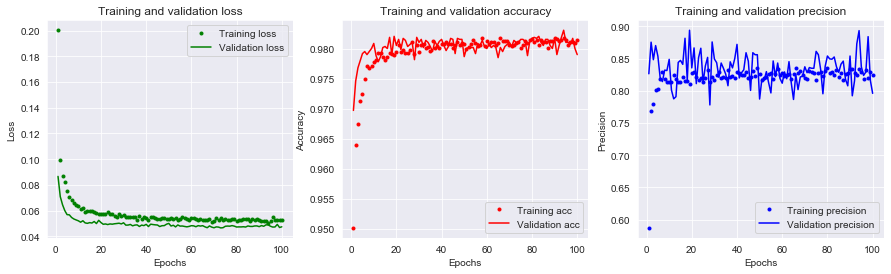

In [35]:
get_history_graph(history_3)

The reduction in nodes has made the model perform better on the test set than on the training set, seemingly solving the issue of overfitting.  As the model trains it does not experience a loss in error or accuracy as the number of epochs increases.  However the precision is still highly variable at the default threshold.  

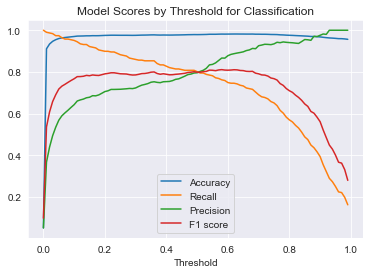

In [36]:
get_score_graph(model_3, X_test, y_test)

In [37]:
model_3.save('../models/model_3.h5')

### Model 4

For the fourth iteration, the reduction in complexity will be tested again, dropping from 8 to 4 nodes in the first layer, and 16 to 8 in the second.

In [38]:
model_4 = Sequential()

# Input layer
model_4.add(Input(18,))

# First hidden layer
model_4.add(Dense(4))
model_4.add(Dropout(0.2))
model_4.add(Activation('relu'))

# First hidden layer
model_4.add(Dense(8))
model_4.add(Dropout(0.2))
model_4.add(Activation('relu'))

# Output layer
model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

custom_compile(model_4)
history_4 = custom_fit(model_4, X_train, y_train, X_test, y_test)

Epoch 1/100
739/739 [==============================] - 1s 1ms/step - loss: 0.2940 - acc: 0.9152 - prec: 0.0405 - recall: 0.0263 - val_loss: 0.1305 - val_acc: 0.9485 - val_prec: 0.8000 - val_recall: 0.0130
Epoch 2/100
739/739 [==============================] - 1s 708us/step - loss: 0.1366 - acc: 0.9503 - prec: 0.8448 - recall: 0.0781 - val_loss: 0.0926 - val_acc: 0.9617 - val_prec: 0.9175 - val_recall: 0.2899
Epoch 3/100
739/739 [==============================] - 1s 700us/step - loss: 0.1056 - acc: 0.9643 - prec: 0.8270 - recall: 0.4151 - val_loss: 0.0744 - val_acc: 0.9763 - val_prec: 0.8884 - val_recall: 0.6221
Epoch 4/100
739/739 [==============================] - 1s 1ms/step - loss: 0.0977 - acc: 0.9673 - prec: 0.8130 - recall: 0.4988 - val_loss: 0.0689 - val_acc: 0.9771 - val_prec: 0.8739 - val_recall: 0.6547
Epoch 5/100
739/739 [==============================] - 1s 1ms/step - loss: 0.0925 - acc: 0.9685 - prec: 0.8140 - recall: 0.5267 - val_loss: 0.0657 - val_acc: 0.9783 - val_prec:

In [39]:
score = model_4.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.05081172659993172
Test accuracy: 0.9803656339645386
Test precision: 0.8715953230857849
Test recall: 0.7296416759490967


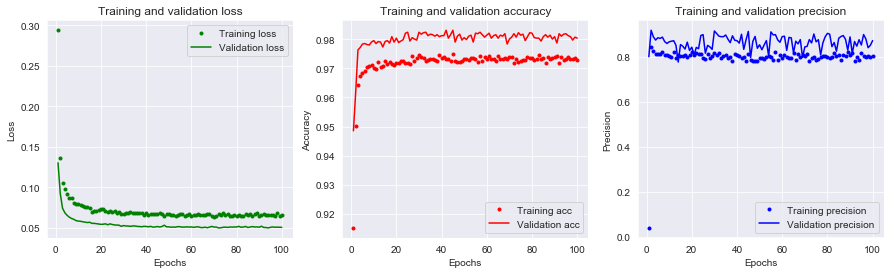

In [61]:
fig = get_history_graph(history_4)
# fig.savefig('../images/model_4_performance.png', bbox_inches='tight')

In the figures above, this model performs the best of all the iterations.  The reduction in complexity, as well as the dropout regularization, has the model consistently perform better on the validation set than on the training set indicating high generalizability. Additionally, the extreme amounts of fluctuations over epochs seems to have been smoothed out considerably.

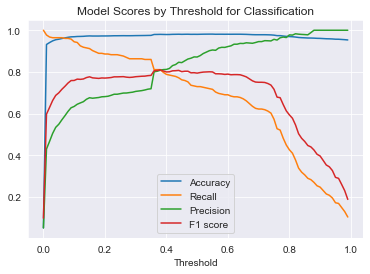

In [60]:
fig = get_score_graph(model_4, X_test, y_test)
# fig.savefig('../images/model_4_threshold_comparison.png', bbox_inches='tight')

Examining the scores by threshold shows a plateau in the f1/recall score that sharply drops off at around 0.75.  At that threshhold the model achieves a precision of ~0.95.  

In [55]:
y_preds = model_4.predict(X_test)
y_preds_temp = [1 if x > 0.74 else 0 for x in y_preds]
print(f1_score(y_test, y_preds_temp))
print(precision_score(y_test, y_preds_temp))
print(recall_score(y_test, y_preds_temp))

0.7370517928286853
0.9487179487179487
0.6026058631921825


In [56]:
model_4.save('../models/model_4.h5')

In [ ]:
df = pd.DataFrame(X)
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

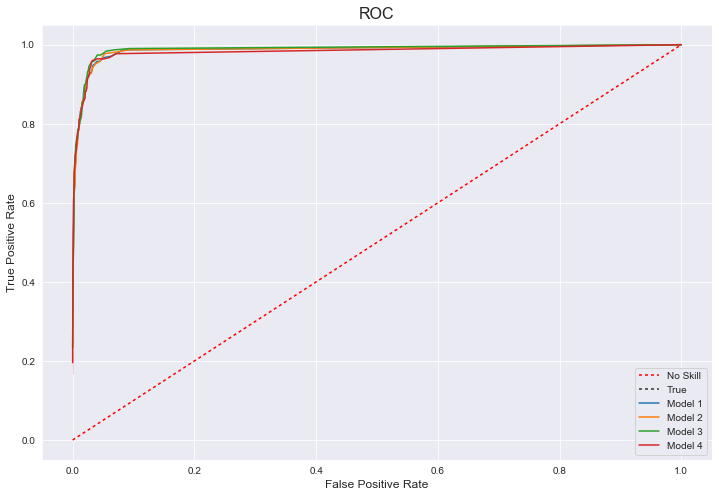

In [59]:
fig = roc_graph([model_1, model_2, model_3, model_4], X_test, y_test);
# fig.savefig('../images/roc_model_comparison.png', bbox_inches='tight')

Above is the ROC curve showing the TPR vs FPR for each of the models.  The models show similar performance in terms of AUC, with Model 3 sligtly outperforming the others.  However due to the generalizability shown by Model 4, that will be the final model used in the analysis. 